# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model to data from [two deep mutational scanning experiments](https://github.com/dms-vep) across Delta and Omicron BA.2 Spike protein.

In [1]:
import os
import sys
from collections import defaultdict
import time
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%matplotlib inline

Read in the dms data and list all available experimental conditions.

In [2]:
func_score_df = pd.read_csv("Delta_BA1_BA2_func_score_df.csv").fillna({"aa_substitutions":""})
avail_conditions = ' '.join(list(func_score_df.condition.unique()))
print(f"The following conditions are available for fitting: \n{avail_conditions}")
func_score_df.sample(frac=1).head().sort_values("condition")

The following conditions are available for fitting: 
Delta-1 Delta-2 Delta-3 Delta-4 Omicron_BA.1-1 Omicron_BA.1-2 Omicron_BA.1-3 Omicron_BA.2-1 Omicron_BA.2-2


,func_score,aa_substitutions,condition
28831,-1.4734,N1192D,Delta-1
65992,1.1206,,Delta-2
81845,-0.3901,K150E G181V K417M Q779K,Delta-3
199503,1.4361,D1153Y,Omicron_BA.1-1
369024,-0.6730,,Omicron_BA.1-3


Choose a reference and all other conditions to be included in the fit. Query the func_score_df sample conditions to be included in a fit.

In [3]:
reference_condition = "Delta-3"
fit_included_conditions = ['Delta-3', 'Omicron_BA.2-1']
func_score_df = func_score_df.query(
    f"condition.isin({fit_included_conditions})"
)

## `MultiDmsData`

After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.

**Note** The current implimentation for string mutation representations is quite slow, we're working on improving this.

In [4]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [5]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet = multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference = reference_condition,
    verbose = True
)

inferring site map for Delta-3
inferring site map for Omicron_BA.2-1
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta-3
is reference, skipping
Converting mutations for Omicron_BA.2-1


We can now view a few useful attributes

In [6]:
data.site_map.head()

,Delta-3,Omicron_BA.2-1
1,M,M
2,F,F
3,V,V
4,F,F
5,L,L


In [7]:
data.mutations[:5]

('M1F', 'M1I', 'M1K', 'M1L', 'M1N')

In [8]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1
0,M1F,M,1,F,5.0,0.0
1,M1I,M,1,I,6.0,6.0
2,M1K,M,1,K,3.0,0.0
3,M1L,M,1,L,3.0,0.0
4,M1N,M,1,N,4.0,0.0


In [9]:
data.conditions

('Delta-3', 'Omicron_BA.2-1')

In [10]:
data.reference

'Delta-3'

In [11]:
data.binarymaps

{'Delta-3': <binarymap.binarymap.BinaryMap at 0x7f47e6f83ac0>,
 'Omicron_BA.2-1': <binarymap.binarymap.BinaryMap at 0x7f47e6f83b80>}

In [12]:
data.non_identical_sites

frozendict.frozendict({'Delta-3': [], 'Omicron_BA.2-1':     Delta-3 Omicron_BA.2-1
19        R              I
27        A              S
156       G              E
213       V              G
339       G              D
371       S              F
373       S              P
375       S              F
376       T              A
405       D              N
408       R              S
417       K              N
440       N              K
452       R              L
477       S              N
484       E              A
493       Q              R
498       Q              R
501       N              Y
505       Y              H
655       H              Y
679       N              K
681       R              H
764       N              K
796       D              Y
950       N              D
954       Q              H
969       N              K})

In [13]:
data.non_identical_mutations

frozendict.frozendict({'Delta-3': '', 'Omicron_BA.2-1': 'R19I A27S G156E V213G G339D S371F S373P S375F T376A D405N R408S K417N N440K R452L S477N E484A Q493R Q498R N501Y Y505H H655Y N679K R681H N764K D796Y N950D Q954H N969K'})

## `MultiDmsModel`

Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.

**Note** Models with the same dataset share the reference. This saves precious memory.

In [65]:
model = multidms.MultiDmsModel(
        data,
        epistatic_model=multidms.model.sigmoidal_global_epistasis,
)

start = time.time()
model.fit(lasso_shift=1e-5, maxiter=500, tol=1e-6)
end = time.time()
print(f"done. fitting time = {round(end - start, 2)} seconds")

done. fitting time = 381.35 seconds


The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictions.

In [66]:
model.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1,β,S_Omicron_BA.2-1
0,M1F,M,1,F,5.0,0.0,-1.260327,0.000000
1,M1I,M,1,I,6.0,6.0,-0.560409,-0.061027
2,M1K,M,1,K,3.0,0.0,-0.910939,0.000000
3,M1L,M,1,L,3.0,0.0,-1.572939,0.000000
4,M1N,M,1,N,4.0,0.0,0.671408,0.000000
...,...,...,...,...,...,...,...,...
9600,S1252T,S,1252,T,27.0,82.0,-0.106769,-0.021843
9601,S1252V,S,1252,V,14.0,61.0,0.286382,0.259033
9602,S1252W,S,1252,W,4.0,22.0,-0.759127,0.423921
9603,S1252Y,S,1252,Y,21.0,108.0,0.825641,0.184509


In [67]:
model.variants_df

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-3,,2566,-0.193454,,2.361828,-0.767280,-0.193454
1,Delta-3,A1015D,1,-3.500000,A1015D,2.013901,-0.851731,-3.500000
2,Delta-3,A1015T G1204D K1245Y,2,-0.710050,A1015T G1204D K1245Y,3.974389,-0.586507,-0.710050
3,Delta-3,A1016D,1,-0.417800,A1016D,3.052532,-0.657720,-0.417800
4,Delta-3,A1016D V1176R,1,-2.225200,A1016D V1176R,0.285309,-1.683407,-2.225200
...,...,...,...,...,...,...,...,...
71854,Omicron_BA.2-1,Y91H N710T A1070G V1129L,2,-2.737200,R19I A27S G156E V213G G339D S371F S373P S375F ...,-2.920736,-3.071422,-2.756042
71855,Omicron_BA.2-1,Y91H T108L D287G A701T S939H,1,-3.500000,R19I A27S G156E V213G G339D S371F S373P S375F ...,-4.535397,-3.179665,-3.518842
71856,Omicron_BA.2-1,Y91N D138N Q474E,2,-2.874750,R19I A27S G156E V213G G339D S371F S373P S375F ...,1.655986,-0.965373,-2.893592
71857,Omicron_BA.2-1,Y91N N603I S1252Y,1,-0.887400,R19I A27S G156E V213G G339D S371F S373P S375F ...,1.775714,-0.924061,-0.906242


### Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

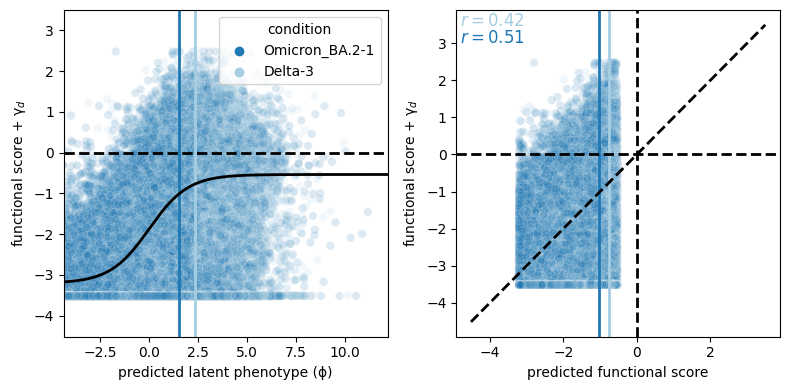

In [68]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
model.plot_epistasis(ax=ax[0], alpha=0.15, show=False)
model.plot_pred_accuracy(ax=ax[1], alpha=0.15, show=False, legend=False)
plt.show

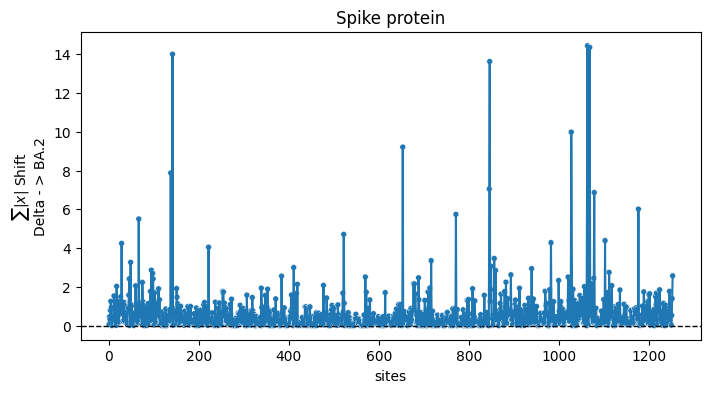

In [69]:
fig, ax = plt.subplots(figsize=[8,4])
agg_func = lambda x: onp.abs(onp.mean(onp.sum(x)))
model.plot_shifts_by_site(ax=ax, condition="Omicron_BA.2-1", agg_func=agg_func, show=False)
ax.set_ylabel("$\sum |x|$ Shift\nDelta - > BA.2")
ax.set_title("Spike protein")
plt.show()

We offer the ability to interactively visualize a model's shift parameters using the `MultiDmsModel.mut_shift_plot()` method which wraps the original viz function from `polyclonal.plot.lineplot_and_heatmap()` as seen [here](https://github.com/jbloomlab/polyclonal/blob/92fee4badb14e1db719074f202b4fab374dd0613/polyclonal/plot.py#L263) 

**NOTE:** Currently, the heatmaps place an "X" at the wildtype for the reference sequence _only_. Note that you quite easily look up the wildtypes for any homolog at a given site using the `MultiDmdData.site_map` property.

In [70]:
data.non_identical_sites

frozendict.frozendict({'Delta-3': [], 'Omicron_BA.2-1':     Delta-3 Omicron_BA.2-1
19        R              I
27        A              S
156       G              E
213       V              G
339       G              D
371       S              F
373       S              P
375       S              F
376       T              A
405       D              N
408       R              S
417       K              N
440       N              K
452       R              L
477       S              N
484       E              A
493       Q              R
498       Q              R
501       N              Y
505       Y              H
655       H              Y
679       N              K
681       R              H
764       N              K
796       D              Y
950       N              D
954       Q              H
969       N              K})

In [71]:
# model
multidms.plot.mut_shift_plot(model, include_beta=False)

/home/jared/miniconda3/envs/multidms-toml/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)